# Set Up/Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# conda activate "/pscratch/sd/m/mansisak/memorization/env/"

In [3]:
# !pip list

In [4]:
#pip install accelerate

In [5]:
import torch
import os
from transformers import AutoModelForCausalLM
from torch.utils.data import DataLoader
from tqdm import tqdm

### TODO: figure out automatically
# device = "cpu"
device = "cuda"

/global/cfs/cdirs/m636/geniesse/envs/memorization/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


# Load in Models

In [6]:
def print_edited_model_paths(parent_path):
    
    total_exp = 0
    for model_name in ['pythia-6.9b-deduped', 'pythia-2.8b-deduped']:
        y_idx = 0
        for step in [36000, 72000, 108000, 143000]:
            for loc_method in [
                  "act",
                  "hc",
                  "slim",
                  "durable",
                  "durable_agg",
                  "random",
                  "random_greedy",
                  "greedy",
              ]:
                
                for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3]:
                    result_path = f"{parent_path}{step}/EleutherAI_edit/{loc_method}/mem/{ratio}"
                    if loc_method not in ["random", "random_greedy"]:
                        if ratio >= 0.1:
                            continue

                    # this ratio is too small for neuron-level methods
                    if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                        if ratio <= 0.0001:
                            continue

                    if loc_method in ["greedy"]:
                        if ratio > 0.00001:
                            continue
                            
                    ######
                    if loc_method in ["greedy", "durable", "durable_agg","act"]:
                        model_path = f'{result_path}/{model_name}'
                        total_exp += 1

                    if loc_method in ["slim", "hc"]:
                        for epochs in [1, 10, 20]:
                            total_exp += 1
                            model_path = f'{result_path}/{epochs}/1000/0.1/0.1/{model_name}'                      

                    if loc_method in ["random", "random_greedy"]:
                        for epochs in [1, 10, 20]:
                            total_exp += 1
                            model_path = f'{result_path}/{epochs}/0.1/0.9/0.0005/{model_name}'
                    if os.path.isfile(model_path):
                        print("edited model exists:", model_path)
                    else:
                        print("edited model doesn't exist yet: ", model_path)

    print("total_expeirments: ", total_exp)



In [7]:
# parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"
parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/"

print_edited_model_paths(parent_path)

edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/act/mem/0.001/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/act/mem/0.01/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/act/mem/0.05/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/hc/mem/0.001/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/hc/mem/0.01/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/hc/mem/0.05/20/1000/0.1/0.1/pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/slim/mem/0.001/20/1000/0.1/0.1/pythia-6.9b-deduped
edit

In [57]:
# Example of how to load in a model:

model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-2.8b-deduped",
    torch_dtype=torch.float16,
    device_map=device
)

# sd_path = '/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/143000/EleutherAI_edit/random_greedy/mem/0.001/20/0.1/0.9/0.0005/pythia-2.8b-deduped'
sd_paths = dict(
    unedited = None,
    good_edit = "/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/143000/EleutherAI_edit/random_greedy/mem/0.001/20/0.1/0.9/0.0005/pythia-2.8b-deduped",
    bad_edit = "/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/143000/EleutherAI_edit/random/mem/0.1/20/0.1/0.9/0.0005/pythia-2.8b-deduped",
)

# choose which model to load
use_model = "bad_edit"
sd_path = sd_paths.get(use_model)

if sd_path is not None:
    sd = torch.load(sd_path, map_location=device)["model_state_dict"]
    if "random" in sd_path:
        for k in sd:
            if "4h" in k:
                #rint(sd[k].shape)
                #rint(k)
                sd[k] = sd[k].T
    model.load_state_dict(sd, assign=True)
model.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2560)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2560, out_features=10240, bias=True)
          (dense_4h_to_h): Linear(in_features=10240, out_features=2560, bias=True)


In [58]:
model.device

device(type='cuda', index=0)

# Load in Data

In [59]:
random_data = torch.load("/pscratch/sd/m/mansisak/memorization/src/data/pythia_mem_data/pile_random_batch.pt")
random_data_pile = torch.reshape(random_data[0:2040], (3264, 80)).to(device)

random_data = random_data_pile[0:1632]
random_data = random_data_pile[0:10] # for testing purposes
extra_data = random_data_pile[1632:]
random_dataloader = DataLoader(random_data, batch_size=1, shuffle=False)
random_dataloader

In [60]:
# need (inputs, targets) format for PyHessian
hessian_dataloader = DataLoader([*zip(random_data, random_data)], batch_size=1, shuffle=False)
hessian_dataloader

# Model Inference

In [48]:
def perplexity(model, dataloader):
    avg_metric = 0
    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            model_output = model(batch, labels=batch)
        loss = model_output.loss
        loss_exp = torch.exp(loss)
        if torch.isinf(loss_exp):
            print(f"Skipping invalid loss...")
            print(f"    {i=}, loss={loss.item()}, exp(loss)={torch.exp(loss).item()}")
        avg_metric += loss_exp
        # print(loss.item())
    return avg_metric / len(dataloader)


def perplexity_criterion(model_output, targets=None):
    loss = model_output.loss
    return torch.exp(loss)


def average_loss(model, dataloader):
    avg_metric = 0
    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            model_output = model(batch, labels=batch)
        loss = model_output.loss
        avg_metric += loss
        # print(loss.item())
    return avg_metric / len(dataloader)


from torch.nn import CrossEntropyLoss
def loss_criterion(model_output, inputs):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = model_output.logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduction="none")
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)
    return (loss_per_sample).mean()


In [49]:
average_loss(model, random_dataloader)

tensor(3.1758, device='cuda:0', dtype=torch.float16)

In [50]:
loss_criterion(model(random_data[:10]), random_data[:10])

tensor(3.1777, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)

# Loss Landscape stuff

In [15]:
import numpy as np
from pyhessian import hessian
from pyhessian.utils import normalization
import copy

import matplotlib.pyplot as plt

In [16]:
def get_params(model_orig, model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(
        model_orig.parameters(), model_perb.parameters(), direction
    ):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

## 1D random directions

Text(0.5, 1.0, 'Loss landscape based on a random direction (good_edit)')

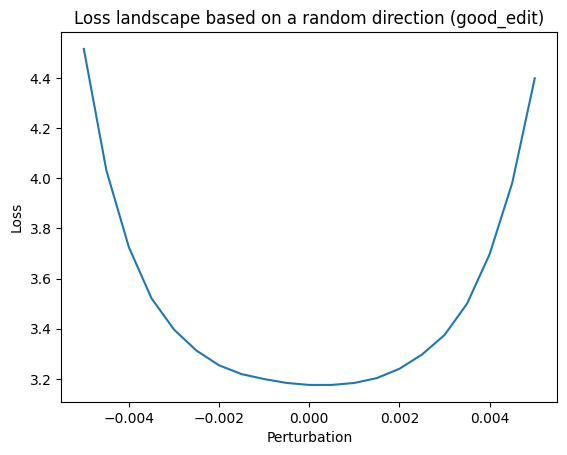

In [53]:
# generate random vector to do the loss plot

### TODO: why does normalization make the direction all zeros ...
v = [torch.randn_like(p) for p in model.parameters()]
# v = normalization(v)

# used to perturb your model 
lams = np.linspace(-0.005, 0.005, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(average_loss(model_perb, random_dataloader).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title(f'Loss landscape based on a random direction ({use_model})')

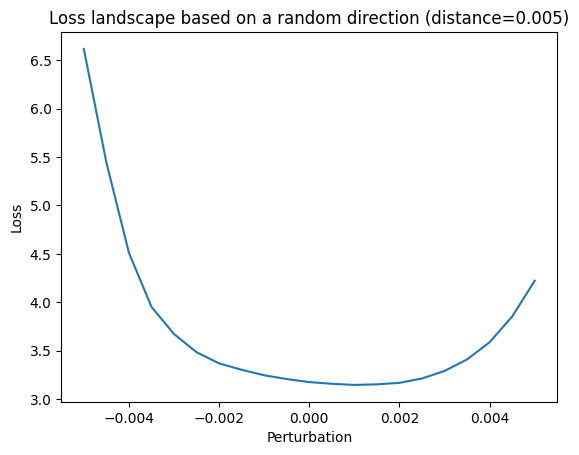

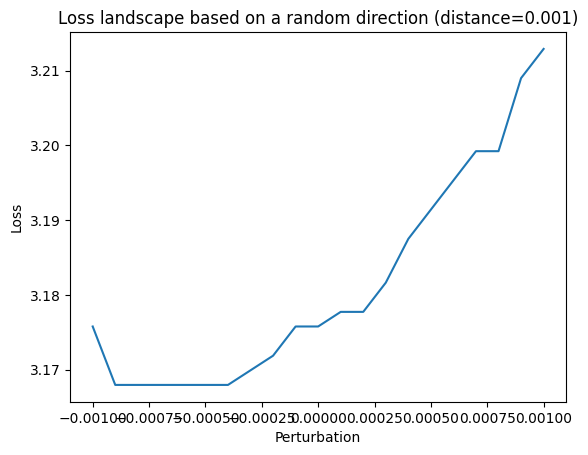

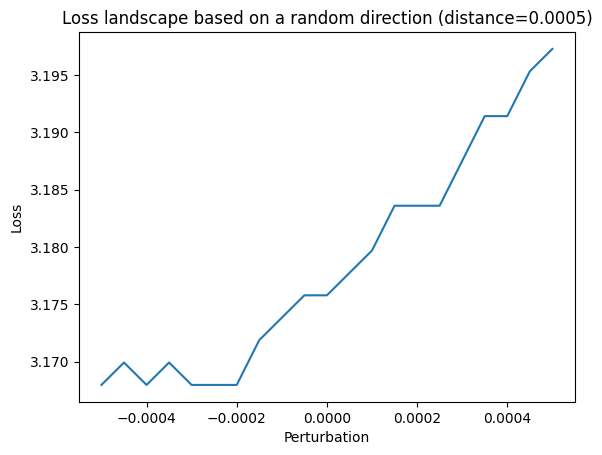

In [55]:
# loop over different distances 

for distance in [0.005, 0.001, 0.0005]:
    
    # generate random vector to do the loss plot

    ### TODO: why does normalization make the direction all zeros ...
    v = [torch.randn_like(p) for p in model.parameters()]
    # v = normalization(v)

    # used to perturb your model 
    lams = np.linspace(-distance, distance, 21).astype(np.float32)

    loss_list = []

    # create a copy of the model
    model_perb = copy.deepcopy(model)
    model_perb.eval()
    model_perb = model_perb.cuda()

    for lam in lams: 
        model_perb = get_params(model, model_perb, v, lam)
        loss_list.append(average_loss(model_perb, random_dataloader).item())

    plt.plot(lams, loss_list)
    plt.ylabel('Loss')
    plt.xlabel('Perturbation')
    plt.title(f'Loss landscape based on a random direction ({distance=})')
    plt.show()

## 1D Gradient direction

Computing loss landscape


Text(0.5, 1.0, 'Loss landscape based on gradient direction (bad_edit)')

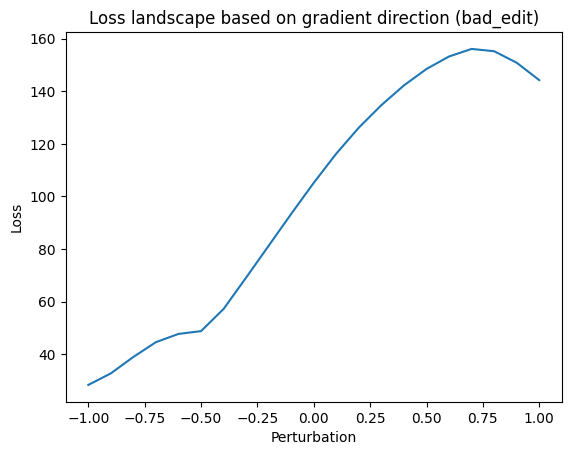

In [61]:
# TODO: figure out why Hessian eigenvalues are nan
# TODO: is the gradient NaN?

dist = 1
lams = np.linspace(-1*dist, 1*dist, 21).astype(np.float32)

model.eval()
model_perb = copy.deepcopy(model)
model_perb.eval()

# generate gradient vector to do the loss plot
loss = loss_criterion(model_perb(random_data[:10]), random_data[:10])
loss.backward()

v = [p.grad.data for p in model_perb.parameters()]
v = normalization(v)
model_perb.zero_grad()


print("Computing loss landscape")
loss_list = [] 
for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(average_loss(model_perb, random_dataloader).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title(f'Loss landscape based on gradient direction ({use_model})')
# Text(0.5, 1.0, f'Loss landscape based on gradient direction ({use_model})')

## 2D random directions

In [ ]:
### TODO: why does normalization make the direction all zeros ...

# generate random vector to do the loss plot

v = [torch.randn_like(p) for p in model.parameters()]
# v = normalization(v)

u = [torch.randn_like(p) for p in model.parameters()]
# u = normalization(u)

# TODO: check to make sure orthoganal
random_directions = [u, v]


In [ ]:
###############################################################################
# Calculate the Random landscape
###############################################################################
# STEPS = 41
STEPS = 5 # for testing
POINTS = STEPS * STEPS

DISTANCE = 0.0005
DISTANCE = 1 # for testing
START = -1 * DISTANCE
END = 1 * DISTANCE

DIM = 2

lams = np.linspace(START, END, STEPS).astype(np.float32)


model.eval()
model_perb = copy.deepcopy(model)
model_perb.eval()

# Generate the loss values array using BFS
# Create a coordinate array for loss values
loss_coordinates_list = []
for i in range(STEPS):
    for j in range(STEPS):
        loss_coordinates_list.append((i, j))
loss_coordinates = np.array(loss_coordinates_list)
print(loss_coordinates.shape)

# Create a data matrix to store loss values
data_matrix = np.empty([POINTS, 1], dtype=float)
data_matrix.fill(-1)
print(data_matrix.shape)

# x, y = iter(train_loader).__next__()

# calculate the hessian loss values
for j in tqdm(
    range(POINTS), desc="Calculating sampling loss values in the subspace"
):
    # adjust the model and fill with a loss with corresponding model parameters
    next_pos = tuple(loss_coordinates[j])
    model_current = copy.deepcopy(model)
    for i in range(DIM):
        model_perb = get_params(
            model_current, model_perb, random_directions[i], lams[next_pos[i]]
        )
        model_current = copy.deepcopy(model_perb)
    # calculate the loss value
    # data_matrix[j] = criterion(model_current(x), y).item()
    data_matrix[j] = average_loss(model_current, random_dataloader).item()
    # print("Loss value: ", data_matrix[j])

print(data_matrix)

In [ ]:
# for creating a responsive plot 
# %matplotlib widget

# importing required libraries 
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 

fig = plt.figure()

# Reshape the data_matrix into a 41x41 grid for plotting
Z = data_matrix.reshape((STEPS, STEPS))

# Generate X and Y coordinates (41x41 grid)
x = np.linspace(0, STEPS-1, STEPS)
y = np.linspace(0, STEPS-1, STEPS)
X, Y = np.meshgrid(x, y)

ax = fig.add_subplot(111, projection='3d')
# Plot the 3D surface with filled colors
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add a color bar for reference
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## 2D Hessian directions

In [18]:
# Compute top-2 Hessian eigenvalues and eigenvectors
def compute_hessian_eigenvalues_and_eigenvectors(
    model, criterion, data_loader, top_n=2
):
    model.eval()

    # images, labels = next(iter(data_loader))
    # images = images.requires_grad_(True)
    # images = next(iter(data_loader))

    # Initialize Hessian computation
    # hessian_comp = hessian(model, criterion, data=(images, images), cuda=True)
    hessian_comp = hessian(model, criterion, dataloader=data_loader, cuda=True)

    # Compute top-n eigenvalues and corresponding eigenvectors
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=top_n)
  
    return top_eigenvalues, top_eigenvectors


# hessian_loader = DataLoader(train_data, batch_size=64, shuffle=False)
hessian_dataloader = DataLoader([*zip(random_data[:1], random_data[:1])], batch_size=1, shuffle=False)
eigenvalues, eigenvectors = compute_hessian_eigenvalues_and_eigenvectors(
    model, loss_criterion, hessian_dataloader
)
print(f"Top-2 Hessian Eigenvalues: {eigenvalues}")
# print(f"Corresponding Eigenvectors: {eigenvectors}")

Top-2 Hessian Eigenvalues: [nan, nan]


In [ ]:
###############################################################################
# Calculate the Hessian Loss
###############################################################################
# STEPS = 41
STEPS = 5 # for testing
POINTS = STEPS * STEPS

# DISTANCE = 1
DISTANCE = 100 # for testing
START = -1 * DISTANCE
END = 1 * DISTANCE

DIM = 2

lams = np.linspace(START, END, STEPS).astype(np.float32)


model.eval()
model_perb = copy.deepcopy(model)
model_perb.eval()

# Generate the loss values array using BFS
# Create a coordinate array for loss values
loss_coordinates_list = []
for i in range(STEPS):
    for j in range(STEPS):
        loss_coordinates_list.append((i, j))
loss_coordinates = np.array(loss_coordinates_list)
print(loss_coordinates.shape)

# Create a data matrix to store loss values
data_matrix = np.empty([POINTS, 1], dtype=float)
# Fill array with initial value (e.g., -1)
data_matrix.fill(-1)
# print(data_matrix)
print(data_matrix.shape)

x, y = iter(train_loader).__next__()

# calculate the hessian loss values
for j in tqdm.tqdm(
    range(POINTS), desc="Calculating sampling loss values in the subspace"
):
    # adjust the model and fill with a loss with corresponding model parameters
    next_pos = tuple(loss_coordinates[j])
    model_current = copy.deepcopy(model)
    for i in range(DIM):
        model_perb = get_params(
            model_current, model_perb, eigenvectors[i], lams[next_pos[i]]
        )
        model_current = copy.deepcopy(model_perb)
    # calculate the loss value
    data_matrix[j] = criterion(model_current(x), y).item()
    # print("Loss value: ", data_matrix[j])

print(data_matrix)

In [ ]:
# for creating a responsive plot 
# %matplotlib widget

# importing required libraries 
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 

fig = plt.figure()

# Reshape the data_matrix into a 41x41 grid for plotting
Z = data_matrix.reshape((STEPS, STEPS))

# Generate X and Y coordinates (41x41 grid)
x = np.linspace(0, STEPS-1, STEPS)
y = np.linspace(0, STEPS-1, STEPS)
X, Y = np.meshgrid(x, y)

ax = fig.add_subplot(111, projection='3d')
# Plot the 3D surface with filled colors
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add a color bar for reference
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
fig, ax = plt.subplots()

# Plot the contour map with your data
contour = ax.contour(
    X, Y, Z, levels=20, cmap="viridis"
)  # You can adjust the number of levels and colormap
ax.clabel(contour, inline=True, fontsize=8)

# Optional: Use contourf to fill the contours
contour_filled = ax.contourf(X, Y, Z, levels=20, cmap='viridis')

# Add a color bar for reference
# fig.colorbar(contour, ax=ax)
cbar = fig.colorbar(contour_filled, ax=ax)
cbar.ax.set_ylabel("Value")

plt.show()

In [ ]:
fig, ax = plt.subplots()

# Plot the contour map with your data
contour = ax.contour(
    X, Y, Z, levels=20, cmap="viridis"
)  # You can adjust the number of levels and colormap
ax.clabel(contour, inline=True, fontsize=8)


# Add a color bar for reference
fig.colorbar(contour, ax=ax)

plt.show()